## Character recognition 

This demo extends the kaggle [competition](https://www.kaggle.com/c/street-view-getting-started-with-julia/details/julia-tutorial). In this demo, we train using images of characters obtained from google view, and also classify test images which are of various sizes. Firstly k-Nearest Neighbor is used to identify the characters. Some of the take aways are how easy it is to build parallelizable and fast systems. We also try out various other methods and show comparisons. 

#### Some key takeaways:
* Ease of prototyping deployable models. 
* Parallelization also very easy to implement. 
* For loops are so fast in Julia.
* How to gain from vectorizations.

Download the following files from [here](https://www.kaggle.com/c/street-view-getting-started-with-julia/data), and place them in the /data directory :

* testResized/
* trainResized/
* sampleSubmission.csv
* trainLabels.csv

In [ ]:
using Images, Colors, DataFrames, TestImages, Gadfly, ArrayFire;

In [2]:
include("$(Pkg.dir())/MLDemos/src/characters/knndemo.jl");

In [3]:
# Some configurations
path = "$(Pkg.dir())/MLDemos/";
imageSize = 400;
# true = for loop, false = vectorised
flag = true
# Read the training labels
labelsInfoTrain = readtable("$(path)data/characters/trainLabels.csv");
# Read the test labels
labelsInfoTest = readtable("$(path)data/characters/testLabels.csv");

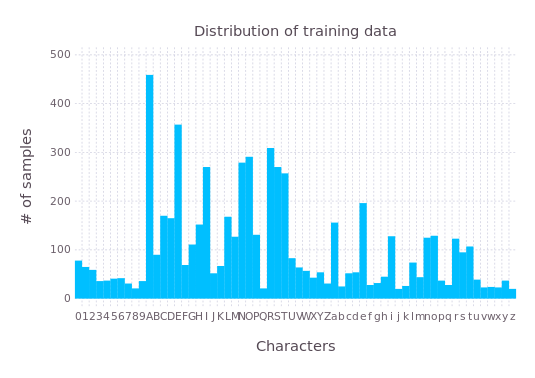

In [4]:
#chars=unique(labelsInfoTrain[:Class])
counts=by(labelsInfoTrain, :Class, nrow);
p1=Gadfly.plot(x = counts[:Class], y=counts[:x1], Guide.xlabel("Characters"), Guide.ylabel("# of samples"), Geom.bar, Guide.title("Distribution of training data"))


 The training images range 1.Bmp to 6283.Bmp, Lets see how the characters look like:

labelsInfoTrain[n,:Class] = "R"


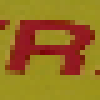

In [7]:
n=6283
@show labelsInfoTrain[n,:Class]
showimtrain(n)

In [13]:
labelsInfoTest

,ID,Class
1,6284,A
2,6285,A
3,6286,A
4,6287,A
5,6288,A
6,6289,A
7,6290,A
8,6291,A
9,6292,A
10,6293,A


In [14]:
#read the images in from the training data.
xTrain = read_data_sv("train", labelsInfoTrain, imageSize, "$(path)data/characters");

#read the test images
xTest = read_data_sv("test", labelsInfoTest, imageSize, "$(path)data/characters");


In [19]:
#Map the training characters to ASCII values
yTrain = map(x -> x[1], labelsInfoTrain[:Class]);
yTrain = int(yTrain)

6283-element DataArrays.DataArray{Int64,1}:
 110
  56
  84
  73
  82
  87
  76
 108
  75
  71
  65
  65
  67
   ⋮
 116
  83
 101
 108
  79
  82
  76
  78
  73
  80
  78
  82

In [20]:
# Transposing the images, so that the columns represent each character.
xTrain = xTrain'
xTest = xTest'

400x6220 Array{Float64,2}:
 0.45098   0.282353  0.113725  0.592157  …  0.329412  0.635294  0.403922
 0.447059  0.286275  0.152941  0.545098     0.341176  0.611765  0.423529
 0.443137  0.309804  0.156863  0.564706     0.345098  0.662745  0.396078
 0.443137  0.301961  0.156863  0.529412     0.345098  0.635294  0.388235
 0.435294  0.309804  0.156863  0.568627     0.341176  0.627451  0.368627
 0.431373  0.341176  0.156863  0.607843  …  0.341176  0.615686  0.368627
 0.458824  0.34902   0.160784  0.568627     0.345098  0.611765  0.411765
 0.462745  0.333333  0.160784  0.576471     0.337255  0.619608  0.501961
 0.447059  0.341176  0.160784  0.537255     0.337255  0.643137  0.690196
 0.462745  0.364706  0.156863  0.560784     0.341176  0.654902  0.819608
 0.458824  0.364706  0.156863  0.580392  …  0.345098  0.627451  0.858824
 0.458824  0.376471  0.156863  0.592157     0.337255  0.65098   0.862745
 0.458824  0.388235  0.156863  0.592157     0.345098  0.631373  0.796078
 ⋮                      

In [30]:
#=
addprocs(1)
@everywhere using DataFrames
include("$(Pkg.dir())/MLDemos/src/characters/knndemo.jl")
procs()
=#

#### Training the model

In [21]:
# Assign the labels to the training images and find the ratio
# of correctly classified labels to the total number of labels

k = 3
@time sumValues = @parallel (+) for i in 1:size(xTrain, 2)
 assign_label(xTrain, yTrain, k, i) == yTrain[i, 1]
end
loofCvAccuracy = sumValues / size(xTrain, 2)

 38.963312 seconds (112.38 M allocations: 2.137 GB, 1.10% gc time)


0.04918032786885246

#### Testing the model

In [22]:
# Running the kNN on test data set
tic()
k = 3 # The CV accuracy shows this value to be the best.                             
yPredictions = @parallel (vcat) for i in 1:size(xTest, 2)
 nRows = size(xTrain, 1)
 imageI = Array(Float32, nRows)
 for index in 1:nRows
  imageI[index] = xTest[index, i]
 end
 assign_label(xTrain, yTrain, k, imageI)
end
toc()

elapsed time: 67.397220768 seconds


67.397220768

#### Assign the predicted values to labelsInfoTest

In [23]:
#Convert integer predictions to character                                            
labelsInfoTest[:Class] = map(Char, yPredictions);

#### Lets actually see how it looks like :

Test images range from 6384.Bmp to 12503.Bmp.

['A']

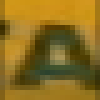

In [35]:
m=7221

show(labelsInfoTest[labelsInfoTest[:ID].==m,:Class])
showimtest(m)

In [36]:
labelsInfoTest

,ID,Class
1,6284,H
2,6285,E
3,6286,R
4,6287,d
5,6288,E
6,6289,C
7,6290,0
8,6291,a
9,6292,8
10,6293,H


## Performance figures :

#### The julia parallel implementation :

We can see that as we add procs, the perfomance improves until nprocs = 6, this is because the data is small and 6 processors are optimal on the test system. 

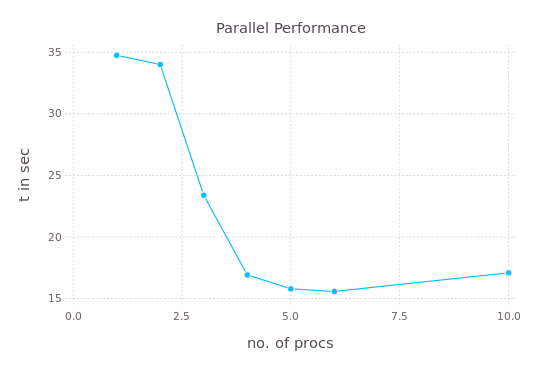

In [59]:
t=[34.749010, 34.001, 23.3853, 16.9243, 15.7945, 15.5830, 17.09088];
N = [1,2,3,4,5,6,10]
Gadfly.plot(x=N, y=t, Geom.point, Geom.line, Guide.xlabel("no. of procs"), Guide.ylabel("t in sec"), Guide.title("Parallel Performance"))

### Advantages of for loops :
#### Distance measure : 
To compute the distance we have used the euclidean distance, which can be computed either as vectorised operation or through for loops. In general, loops are much slower in languages such as Python, R, and Matlab. Thanks to the typing and clever compiler decisions that happen behind the scenes in Julia, the opposite is often true: for loops can be faster than vectorized operations!

In [63]:
# Vectorised euclidean distance
function euclidean_distance_vectorise(a, b)
   return dot(a-b, a-b) 
end

euclidean_distance_vectorise (generic function with 1 method)

In [64]:
# For loop cosine measure
function euclidean_distance_for(a, b)
 distance = 0.0 
 for index in 1:size(a, 1) 
  distance += (a[index]-b[index]) * (a[index]-b[index])
 end
 return distance
end

euclidean_distance_for (generic function with 1 method)

In [85]:
#=
a = rand(100000)
b = rand(100000)
@time euclidean_distance_for(a,b)
@time euclidean_distance_vectorise(a,b)
af = AFArray(a)
bf = AFArray(b)
@time euclidean_distance_vectorise(af,bf)
=#

#### Plot showing the performance of for loop Vs Vectorised Vs ArrayFire Vectorised

In [92]:
AF = AFArray(A)

100x100 ArrayFire.AFArray{Float64,2}:
 0.628316   0.315739   0.152826   …  0.8603     0.187177   0.451568 
 0.403351   0.470024   0.822571      0.852278   0.0904417  0.863147 
 0.619798   0.353294   0.202953      0.327211   0.982492   0.483531 
 0.043397   0.583237   0.325377      0.12777    0.761557   0.114862 
 0.533461   0.251879   0.67897       0.1833     0.324258   0.459648 
 0.106465   0.947179   0.758074   …  0.733536   0.615292   0.775752 
 0.473022   0.521529   0.72951       0.0312925  0.471481   0.797548 
 0.0688135  0.546529   0.680704      0.714711   0.328781   0.75153  
 0.677659   0.984655   0.56293       0.357795   0.653301   0.0189638
 0.525585   0.654143   0.626021      0.229998   0.215923   0.601678 
 0.584329   0.0473929  0.694938   …  0.836697   0.999277   0.524764 
 0.676949   0.513726   0.97657       0.725732   0.984024   0.207123 
 0.0768305  0.419259   0.685677      0.722134   0.480267   0.706955 
 ⋮                                ⋱                              

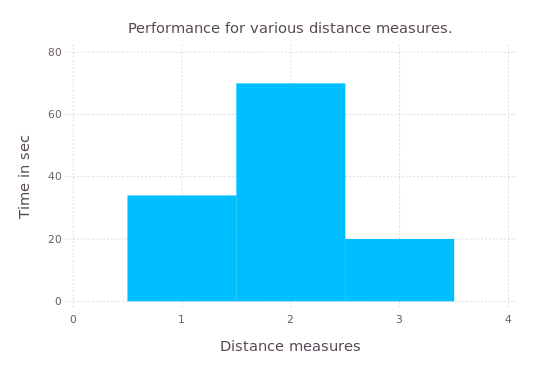

In [101]:
t2 = [34,70,20]

p1=Gadfly.plot( y=t2, Guide.xlabel("Distance measures"), Guide.ylabel("Time in sec"), Geom.bar, Guide.title("Performance for various distance measures."))


#### Performance vs sklearn

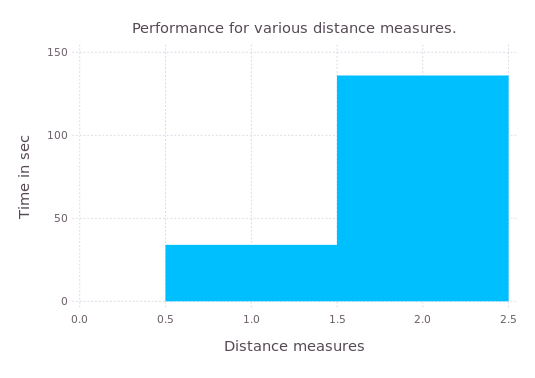

In [102]:
t2 = [34,136]

p1=Gadfly.plot( y=t2, Guide.xlabel("Distance measures"), Guide.ylabel("Time in sec"), Geom.bar, Guide.title("Performance for various distance measures."))
